# pipeline for GWAS analysis
### &#9675; ***step1:*** SNP callling
### &#9675; ***step2:*** GWAS analysis
### &#9675; ***step2:*** Results visulize

###  **step1: SNP calling process | Output: vcf file with SNPs**
**Website:** https://gencore.bio.nyu.edu/variant-calling-pipeline-gatk4/.    
**Paper for prameters:** 
https://www.nature.com/articles/s41598-022-26181-3   
**Note:** I  have a problem about installing the gatka software. The error information is : this is a error hhhhh! I need do export PATH=…… before running it. 

This is the workflow for snp calling


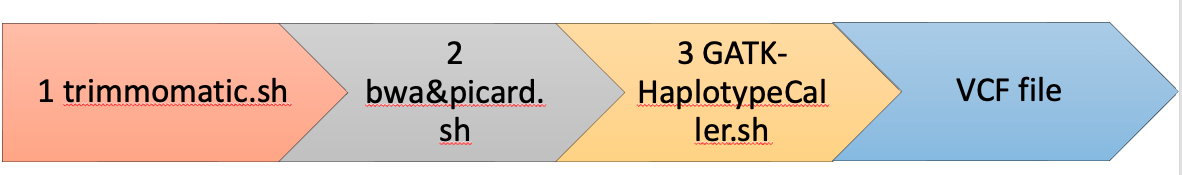

In [ ]:
from IPython.display import Image
print ("This is the workflow for snp calling")
Image("/Users/zhiqinlong/Desktop/workflow_snpcalling.png")

### **step1.1** Filter the raw fastq files

In [ ]:
#!/bin/bash
while read line
do
	temp=${line##*/}
	sample=${temp%-*}
	outdir=$OUTDIR/$sample
	in_file1=$line
	in_file2=${line%R*}R2.fastq.gz
	paired_file1temp=${in_file1##*/}
	paired_file2temp=${in_file2##*/}
	paired_file1=${paired_file1temp%fastq*}clean.fq.gz
	paired_file2=${paired_file2temp%fastq*}clean.fq.gz
	unpaired_file1=${paired_file1temp%fastq*}unpaireq.fq.gz
	unpaired_file2=${paired_file2temp%fastq*}unpaireq.fq.gz
	echo "cd $outdir;/data/apps/jdk/jdk1.8.0_131/bin/java -jar /data/apps/trimmomatic/Trimmomatic-0.36/trimmomatic-0.36.jar PE -threads 1 $in_file1 $in_file2 $paired_file1 $unpaired_file1 $paired_file2 $unpaired_file2 LEADING:20 TRAILING:20 SLIDINGWINDOW:4:20 MINLEN:36;rm $unpaired_file1 $unpaired_file2" >> $Userhome/tri.sh
done <$Userhome/rawfile

### **step1.2** align the raw reads to the reference genome.

In [ ]:
#!/bin/bash
for indir in $INDIR/*
do
	for file in `find  $indir -name "*R1.clean.fq.gz"`
	do
		outdir=${indir##*/}
		infile_fq_1=$file
		infile_fq_2=${file%R*}R2.clean.fq.gz
		temp=${infile_fq_1##*/}
		temp2=${temp%%_*}
		sample=${temp2%%.*}		
		outfile_sam=$sample.sam
		outfile_bam=$sample.sort.bam
		outfile_bam_stat=${outfile_bam%.*}.stat
		outfile_bam_bai=$sample.sort.bai
		outfile_depth=$sample.depth.txt
		outfile_rmdup=$sample.sort.rmdup.bam
		outfile_rmdup_bai=$sample.sort.rmdup.bai
		outfile_metrics=$sample.metrics
		echo "cd $OUTDIR/$outdir;$BWA mem -t 6 -R '@RG\tID:$sample\tSM:$sample\tLB:$sample' $reference $infile_fq_1 $infile_fq_2 | $SAMTOOLS sort -O BAM -T $sample -l 3 -o $outfile_bam;$SAMTOOLS flagstat $outfile_bam > $outfile_bam_stat;$SAMTOOLS index $outfile_bam $outfile_bam_bai;$SAMTOOLS depth $outfile_bam > $OUTDIR_depth/$outfile_depth;$JAVA -Xmx2500m -jar $PICARD MarkDuplicates INPUT=$outfile_bam OUTPUT=$OUTDIR_picard/$outdir/$outfile_rmdup METRICS_FILE=$OUTDIR_picard/$outdir/$outfile_metrics REMOVE_DUPLICATES=true ASSUME_SORTED=true VALIDATION_STRINGENCY=LENIENT;$SAMTOOLS index $OUTDIR_picard/$outdir/$outfile_rmdup $OUTDIR_picard/$outdir/$outfile_rmdup_bai" >> /w/00/u/user201/bwa_picard.sh
	done
done


### **step1.3** SNP calling use GATK
### **Output:** VCF file, VCF file explaination see below.

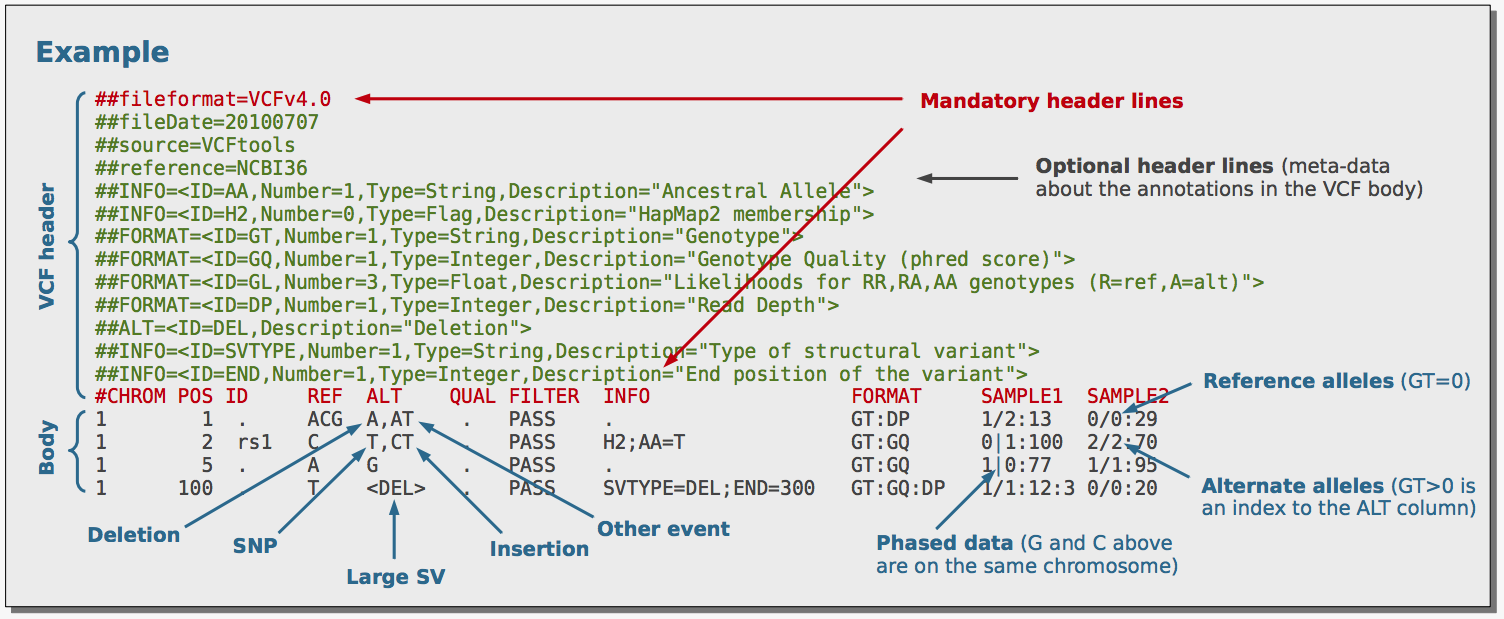

In [ ]:
from IPython.display import Image
Image("/Users/zhiqinlong/Desktop/vcf_format.png")

In [ ]:
#!/bin/bash
for indir in $INDIR/*
do
	for file in `find  $indir -name "*sort.rmdup.bam"`
	do
		outdir=${indir##*/}
		infile=$file
		temp=${infile##*/}
		outfile_gvcf=${temp%sort*}g.vcf.gz
		echo "source ~/.bashrc;cd $OUTDIR/$outdir;/data/apps/jdk/jdk1.8.0_131/bin/java -Xmx16g -jar /data/apps/gatk/gatk-4.0.5.1/gatk-package-4.0.5.1-local.jar HaplotypeCaller --native-pair-hmm-threads 6 -R $reference -I $infile -O $outfile_gvcf -ERC GVCF --heterozygosity 0.01" >>  /w/00/u/user201/gatk.sh
	done
done

### **step2**  Running GWAS analysis
emmax -v -d 10 -t [tped_prefix] -p [pheno_file] -k [k_matrix] -c [PLINK-PCA].cov -o [out_prefix]. 
**GWAS results**
SNP ID
Beta: estimated effect size of the SNP on the trait being studied. A positive beta value indicates an increase in the trait for each copy of the effect allele, while a negative beta value indicates a decrease.
Standard Error of beta: measure of the uncertainty or precision associated with the estimated beta coefficient. A smaller standard error suggests a more precise estimate.
P-value: measure of the evidence against a null hypothesis (no association between the SNP and the trait). A smaller p-value indicates stronger evidence against the null hypothesis. In the context of GWAS, a commonly used threshold for significance is 0.05.



### **step3**  Visulize GWAS analysis results

[1] 4.966095

[1] 5.267125

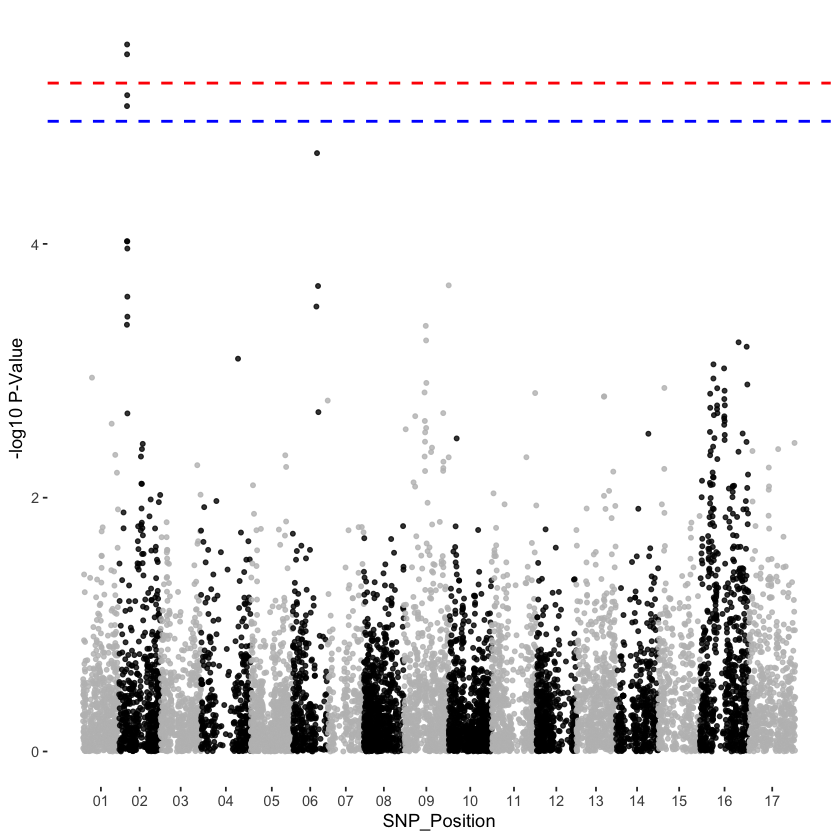

In [2]:

setwd("/Users/zhiqinlong/Downloads")  # Set this to where you saved your xxx.ps file
#Set dir
#Load packages
suppressMessages(library(data.table))
suppressMessages(library(tidyverse))
suppressMessages(library(ggplot2))
#####################
# Part 2 : Load EMMAX (GWAS) results
#####################

a <- fread("EMMAX_output_SNP_20251017.ps", header =F)
colnames(a)[1] <- "SNP"
colnames(a)[4] <- "P"

a2 <- a[ ,c(1,4)]

#SNP use this
a3 <- a2 %>% separate(SNP,into = c("CHR","BP"), sep = ":" , remove = F)
a3[,3] <- as.numeric(unlist(a3[,3])) #use UNLIST!!

rm(a2)

#####################
# Part 3 : Set thershold
#####################
#I used 9249 SNPs, threshold is even bigger!
ben_threshold <- -log10(0.1/9249); ben_threshold
ben_threshold.5 <- -log10(0.05/9249); ben_threshold.5

#####################
# Part 4 : Calculate cumulated genomic position (for X axis)
#####################

gwasResults <- a3

#Position of the Chr
don <- gwasResults %>%
  
  # Compute chromosome size
  group_by(CHR) %>%
  summarise(chr_len=max(BP)) %>%
  
  # Calculate cumulative position of each chromosome
  mutate(tot=cumsum(chr_len)-chr_len) %>%
  select(-chr_len) %>%
  
  # Add this info to the initial dataset
  left_join(gwasResults, ., by=c("CHR"="CHR")) %>%
  
  # Add a cumulative position of each SNP
  arrange(CHR, BP) %>%
  mutate( BPcum=BP+tot)

#####################
# Part 5 : Define X axis
#####################

axisdf = don %>% group_by(CHR) %>% summarize(center=( max(BPcum) + min(BPcum) ) / 2 )
X_axis <- gsub("Ha412HOChr","", axisdf$CHR)

#####################
# Part 6 : P -> Log10(P)
#####################

don$logP <- (-log10(don$P))
#####################
# Part 7 : Plotting!
#####################

ggplot(don,aes(x=BPcum, y=-log10(P))) +
  geom_point(aes(color=as.factor(CHR)), alpha=0.8, size= 1) +
  scale_color_manual(values = rep(c("grey", "black"), 22 )) +
  geom_hline(yintercept=as.numeric(ben_threshold.5), linetype="dashed",color = "red", size=0.8) +
  geom_hline(yintercept=as.numeric(ben_threshold), linetype="dashed",color = "blue", size=0.8) +
  # custom X axis:
  scale_x_continuous( label = X_axis, breaks= axisdf$center ) +
  
  # Custom the theme:
  theme_bw() +
  theme(
    legend.position="none",
    panel.border = element_blank(),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    panel.background = element_blank(),
    strip.background = element_blank()
  )+
  labs(
    y = "-log10 P-Value",
    x = "SNP_Position")


#####################
# Part 8 : Extract top 10 above the thershold -> SAVE
#####################

don2 <- don[order(don$logP,decreasing = T),]
don_top10 <- don2[1:10,]
